In [1]:
#!cp /kaggle/input/10-keras-baseline-seq2seq-ensemble/submission.csv /kaggle/working/submission.csv
#import sys
#sys.exit(0)

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras
from keras.regularizers import l2

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

2024-07-04 02:08:22.754329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 02:08:22.754427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 02:08:22.890644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
0.4.26


In [3]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [4]:
SEED = 2024  # 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [5]:
TRAIN = False
#MODEL_PATH = "/kaggle/input/leap-climsim-keras-baseline-seq2seq-v01"
MODEL_PATH = "/kaggle/input/01-keras-baseline-seq2seq"
DATA_MODELS = [f"{MODEL_PATH}/01-keras-baseline-seq2seq.keras", 
               f"{MODEL_PATH}/04-keras-baseline-seq2seq.keras"]
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_TFREC = "/kaggle/input/leap-train-tfrecords"

In [6]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [7]:
def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']

In [8]:

train_options = tf.data.Options()
train_options.deterministic = True


In [9]:

BATCH_SIZE = 1024
EPOCHS = epochs = 100


In [10]:

valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

ds_valid = (
    tf.data.Dataset.from_tensor_slices(valid_files)
    .with_options(train_options)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file)
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .cache()
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)


In [11]:
train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

In [12]:

valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

ds_valid = (
    tf.data.Dataset.from_tensor_slices(valid_files)
    .with_options(train_options)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file)
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .cache()
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)


In [13]:

train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]

#BATCH_SIZE = 1024

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file)
        .map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .cache()
        .shuffle(2048)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)


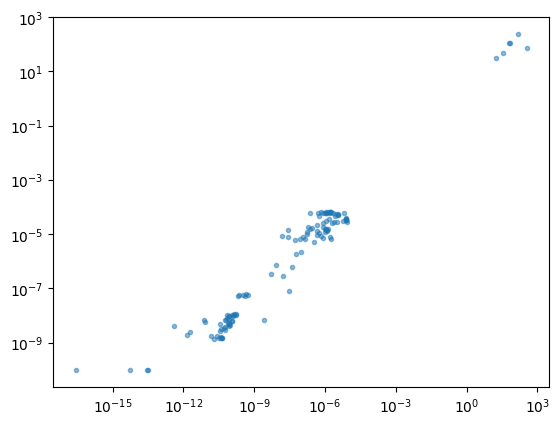

In [14]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(20 if is_interactive() else 1000))

mean_y = norm_y.mean
stdd_y = keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

plt.scatter(
    mean_y.squeeze(),
    stdd_y.squeeze(),
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')


In [15]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)

### Model definition & Training

In [16]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

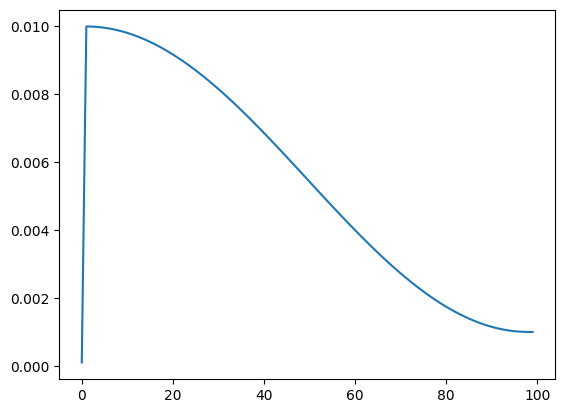

In [17]:
#epochs = 100  # 50 # 25  # 15  # 12
learning_rate = 1e-2

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-4, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [18]:

# Define and adapt the normalization layer
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x))


In [19]:
keras.utils.clear_session()

from keras.regularizers import l2

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

def residual_block(x, units, activation='relu'):
    residual = keras.layers.Conv1D(units, 1, padding='same')(x)  # Match the dimensions
    x = keras.layers.Dense(units, activation=activation, kernel_regularizer=l2(0.001))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(units, activation=activation, kernel_regularizer=l2(0.001))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.add([x, residual])
    return x

def build_cnn(activation='relu'):
    return keras.Sequential([
        keras.layers.Conv1D(256, 3, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(64, 3, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(64, 3, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(32, 3, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.GRU(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=activation, kernel_regularizer=l2(0.001)),
    ])

def build_cnn11(activation='relu'):
    return keras.Sequential([
        keras.layers.Conv1D(256, 11, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(128, 11, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(64, 11, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(64, 11, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(32, 11, padding='same', activation=activation, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.GRU(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=activation, kernel_regularizer=l2(0.001)),
    ])

X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)

e11 = e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
e = build_cnn()(e)
e11 = build_cnn11()(e11)
# add global average to allow some comunication between all levels even in a small CNN
e = e0 + e + e11 + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)

# Adding residual blocks
e = residual_block(e, 512)
e = residual_block(e, 256)
e = residual_block(e, 128)

p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

p_flat = p_all[:, :, 6:6 + 8]
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8

P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# build & compile
model = keras.Model(X_input, P)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

'''keras.utils.clear_session()


def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)


def build_cnn(activation='relu'):
    return keras.Sequential([
        # Première couche Conv1D
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        # Deuxième couche Conv1D
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        # Troisième couche Conv1D
        keras.layers.Conv1D(64, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        # Couche Dropout pour la régularisation
        keras.layers.Dropout(0.3),
        # Couche LSTM pour capturer les dépendances temporelles
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.BatchNormalization(),
        # Couche GRU pour capturer les dépendances temporelles
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.BatchNormalization(),
        # Couche Dense finale pour ajuster la sortie à la taille 64
        keras.layers.Dense(64, activation=activation),
    ])

def build_cnn11(activation='relu'):
    return keras.Sequential([
        # Première couche Conv1D
        keras.layers.Conv1D(256, 11, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        # Deuxième couche Conv1D
        keras.layers.Conv1D(128, 11, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        # Troisième couche Conv1D
        keras.layers.Conv1D(64, 11, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        # Couche Dropout pour la régularisation
        keras.layers.Dropout(0.3),
        # Couche LSTM pour capturer les dépendances temporelles
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.BatchNormalization(),
        # Couche GRU pour capturer les dépendances temporelles
        keras.layers.GRU(64, return_sequences=True),
        keras.layers.BatchNormalization(),
        # Couche Dense finale pour ajuster la sortie à la taille 64
        keras.layers.Dense(64, activation=activation),
    ])

X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)

e11 = e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
e = build_cnn()(e)
e11 = build_cnn11()(e11)
# add global average to allow some comunication between all levels even in a small CNN
e = e0 + e + e11 + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)

p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

p_flat = p_all[:, :, 6:6 + 8]
p_flat = keras.ops.mean(p_flat, axis=1)
assert p_flat.shape[-1] == 8

P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# build & compile
model = keras.Model(X_input, P)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()
'''

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      1,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 64)    │    247,648 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 64)    │    755,552 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 64)     │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,001,710 (7.64 MB)

 Trainable params: 1,993,966 (7.61 MB)

 Non-trainable params: 7,744 (30.25 KB)

"keras.utils.clear_session()\n\n\ndef x_to_seq(x):\n    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))\n    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))\n    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))\n    x_flat = keras.ops.repeat(x_flat, 60, axis=1)\n    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)\n\n\ndef build_cnn(activation='relu'):\n    return keras.Sequential([\n        # Première couche Conv1D\n        keras.layers.Conv1D(256, 3, padding='same', activation=activation),\n        keras.layers.BatchNormalization(),\n        # Deuxième couche Conv1D\n        keras.layers.Conv1D(128, 3, padding='same', activation=activation),\n        keras.layers.BatchNormalization(),\n        # Troisième couche Conv1D\n        keras.layers.Conv1D(64, 3, padding='same', activation=activation),\n        keras.layers.BatchNormalization(),\n        # Couche Drop

In [20]:
# Define and adapt the normalization layer
#norm_x = keras.layers.Normalization()
#norm_x.adapt(ds_train.map(lambda x, y: x))


In [21]:
if TRAIN:
    ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
    ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

    history = model.fit(
        ds_train_target_normalized,
        validation_data=ds_valid_target_normalized,
        epochs=epochs,
        verbose=1 if is_interactive() else 2,
        callbacks=[
            keras.callbacks.ModelCheckpoint(filepath='model.keras')
        ]
    )
    models = [model]
else:
    models = [keras.models.load_model(model_path) for model_path in DATA_MODELS]

In [22]:
if TRAIN:
    plt.plot(history.history['loss'], color='tab:blue')
    plt.plot(history.history['val_loss'], color='tab:red')
    plt.yscale('log');
    plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step
[ 9.68975593e-01  9.84513800e-01  9.91410126e-01  9.94152640e-01
  9.95900424e-01  9.97857388e-01  9.97518991e-01  9.96789713e-01
  9.96164297e-01  9.96283794e-01  9.96077564e-01  9.95423665e-01
  9.94337776e-01  9.92958243e-01  9.91395114e-01  9.88996177e-01
  9.63709203e-01  6.63054585e-01  4.99815165e-01  5.13120426e-01
  5.85820932e-01  6.30347612e-01  6.58746382e-01  7.05870430e-01
  7.41988359e-01  7.78915028e-01  8.27540689e-01  8.69610609e-01
  8.85699321e-01  8.97705141e-01  9.09276725e-01  9.09825543e-01
  9.07554686e-01  8.96585310e-01  8.83465434e-01  8.62127635e-01
  8.37568038e-01  8.06841141e-01  7.79593655e-01  7.43951540e-01
  7.03156222e-01  6.66212355e-01  6.35748789e-01  6.11129306e-01
  6.00629596e-01  5.76742624e-01  5.45071591e-01  5.17578027e-01
  5.05039042e-01  4.97158071e-01  4.83284368e-01  4.82766818e-01
  4.77493093e-01  4.84528413e-01  4.91980407e-01  5.12729137e-01
  5.351678

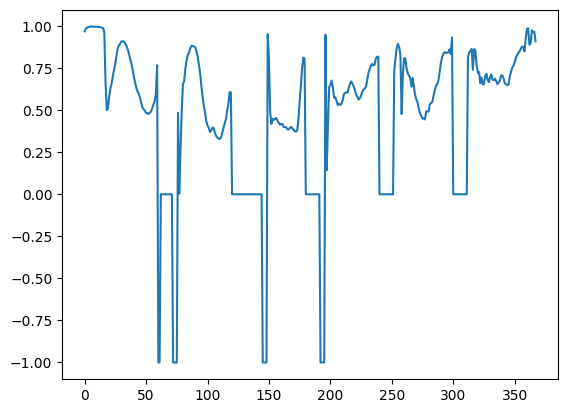

In [27]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = np.array([train_model.predict(ds_valid, batch_size=BATCH_SIZE) for train_model in models])
p_valid = np.mean(p_valid, axis=0)
p_valid = p_valid * stdd_y + mean_y

scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

print(scores_valid)
mask = scores_valid <= 1e-3
print(f"Number of under-performing targets: {sum(mask)}", f"Clipped score: {scores_valid.clip(0, 1).mean()}")
del y_valid, p_valid
gc.collect();

# Submission

In [24]:
sample = pl.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

df_test = (
    pl.scan_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv")
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

p_test = np.array([train_model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) for train_model in models])
p_test = np.mean(p_test, axis=0)
p_test = p_test * stdd_y + mean_y
p_test = np.array(p_test)
p_test[:, mask] = mean_y[:, mask]

# correction of ptend_q0002 targets (from 12 to 29)
df_p_test = pd.DataFrame(p_test, columns=TARGETS)

for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200
    
p_test = df_p_test.values

submission = sample.to_pandas()
submission[TARGETS] = submission[TARGETS] * p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")

153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step
